# Filtrar y procesar la señal de EEG
**Materias relacionadas** : Instrumentación Biomédica, Electrofisiología, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.

**Antecedentes**: Notebook 1

En este notebook abordaremos el filtrado y procesamiento de la señal de EEG. Empezaremos hablando del filtrado.
Existen buenas razones para filtrar la señal de EEG. Principalmente:
1. Eliminación de ruido. Las señales de EEG tienen distintas fuentes de ruido como: ruido de línea proveniente de las fuentes de corriente alterna. (Pant, 2024)
2. Facilitación de la visualización y análisis. Con una señal filtrada se resaltan características relevantes de la señal y esto permite identificar visualmente eventos y patrones de actividad cerebral. Obtener visualizaciones es parte del análisis de la señal. (Schreiber, 2017)
3. Preparación para análisis posteriores. Entre los análisis que se pueden realizar encontramos: detección de eventos, extracción de características y clasificación. (Shoka, 2019)
4. Análisis de frecuencias de EEG. Este es un tema que abordaremos con detalle en el notebook 3. Utilizando distintas técnicas podemos hacer un análisis de las bandas de frecuencia de la señal. (Vallat, 2019)

## Filtrado de la señal

En el notebook anterior trabajaos con una visualización cruda. Donde se ven artefactos y fluctuaciones. Una forma de mitigar estos efectos es usar filtros pasabandas.


## Tipos de Filtros y su Aplicación en EEG 


|Filtro|Función|Aplicación|
|--|--|--|
|Pasabajas|Atenuar las frecuencias por encima de una frecuencia de corte determinada| * Eliminar el ruido de alta frecuencia, por ejemplo el proveniente de la actividad muscular. * Aislar los componentes de baja frecuencia|
|Pasaaltas|Atenuar las frecuencias por encima de una frecuencia de corte determinada| * Eliminar el ruido causado por los cambios de potencial de la piel. * Aislar componentes de alta frecuencia|
|Pasabandas| Permite pasar un rango de frecuencias, dando una frecuencia de corte alta y una frecuencia de corte baja| Obtener bandas de frecuencia específica dada su frecuencia de corte baja y su frecuencia de corte alta|

Obtenida con información de Baranowski, 2017.

## Orden de los filtros
El orden de un filtro se refiere al número de polos o ceros que tiene la función de transferencia del filtro. Una función de transferencia es la representación matemática de cómo un sistema transforma una señal de entrada en una de salida (Rader, 1917). Mayor orden en el filtro implica mayor complejidad y mayor capacidad para aproximar una respuesta en frecuencia ideal (Widmann, 2015).


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftshift
import waveb
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter
from scipy.integrate import simps #Usando la regla de Simpson para calcular el área bajo la curva

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fft, fftshift
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter

In [7]:
carpeta = os.abspath('/Users/yann/Documents/Datos/EEG/') #localización del 
#archivo en tu computadora
datos = pd.read_csv(carpeta +'/H24_OC_OA.csv') #creación de un dataframe
#al que únicamente debes modificar el nombre del archivo con su extensión
datos #comando para presentar el dataframe

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,4339.49,4521.03,4187.69,4627.69,4339.49,4112.31,4348.72,4252.31,4932.82,4447.69,4475.38,4738.46,4420.51,4598.46
1,4346.67,4527.18,4202.05,4633.85,4342.05,4122.05,4366.67,4267.69,4949.74,4465.64,4485.64,4749.74,4432.82,4611.28
2,4350.26,4540.00,4207.18,4643.08,4341.54,4122.05,4374.87,4271.28,4954.36,4462.56,4485.13,4747.18,4430.77,4612.31
3,4337.95,4530.77,4198.46,4638.46,4336.92,4118.97,4372.31,4258.97,4936.92,4441.03,4472.31,4734.87,4413.85,4598.46
4,4334.87,4519.49,4189.23,4629.23,4342.05,4118.97,4369.74,4245.64,4923.08,4436.41,4471.28,4731.79,4416.41,4596.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23122,4414.87,4522.05,4201.54,4683.08,4384.62,4105.64,4361.54,4217.44,4892.82,4362.05,4493.85,4757.44,4426.67,4627.18
23123,4413.85,4524.10,4200.51,4685.64,4388.72,4106.15,4349.74,4196.92,4875.90,4346.67,4476.92,4749.74,4412.82,4614.36
23124,4416.41,4523.08,4204.62,4690.26,4391.28,4102.05,4337.44,4183.59,4875.90,4349.74,4477.95,4752.82,4412.31,4616.41
23125,4413.85,4520.51,4205.13,4687.69,4383.08,4094.36,4336.41,4183.59,4875.90,4352.31,4485.64,4753.33,4413.33,4617.95



### Filtro pasabandas de Butterworth, orden 3


Un filtro pasabandas de Butterworth actúa como una ventana que deja pasar solo las señales que se encuentran dentro de un rango específico de frecuencias. Un filtro de Butterworth tiene las siguientes características:

* Permitir el paso de señales dentro de un rango específico de frecuencias, conocido como banda de paso.
* Atenuar las señales fuera de la banda de paso, en las bandas de rechazo inferior y superior.
* Tener una respuesta en frecuencia plana en la banda de paso, sin ondulaciones significativas.
* Tener una transición gradual entre la banda de paso y las bandas de rechazo.
* Su función de transferencia se caracteriza por una atenuación monótona en las bandas de rechazo.

Ventajas:

Respuesta en frecuencia plana en la banda de paso.
Transición gradual entre la banda de paso y las bandas de rechazo.
Fácil de implementar con componentes electrónicos.
Comportamiento estable y predecible.

## Aplicación de un filtro pasabandas de orden 3.

En este caso el filtrado va de 2 a 45 Hz pues es el rango que nos interesa filtrar. Tomando en cuenta que estamos trabajando con una frecuencia de muestreo de 128 Hz tenemos parámetros para construir el filtro. El teorema de muestro de Nyquist-Shannon establece que para representar fielmente en el dominio digital una señal la frecuencia de Nyquist se calcula con la siguiente fórmula:

$f_n = \frac{f_s}{2}$

Aplicando este cálculo para la frecuencia de interés que estamos trabajando, el cálculo se haría de la siguiente forma:

$f_n = \frac{f_s}{2}$

$f_n = \frac{128 Hz}{2}$

$f_n = 64 Hz $

De lo anterior sabemos que la máxima frecuencia representable para construir el filtro es de 64 Hz. Ahora llevamos este cálculo a los parámetros fisiológicos que nos interesan para la construcción del filtro. Al tratarse de un filtro pasabandas debemos fijar el ancho de banda inferior y el ancho de banda superior.

Respecto a la frecuencia baja, queremos usarla para eliminar el ruido que pueda venir de la actividad cardiaca. Sabemos que la frecuencia cardiaca se encuentra entre 50 y 100 latidos por minuto. Si la frecuencia inferior fuera de 1 Hz únicamente estaría representada la actividad que se encuentra en un valor máximo de 64 latidos por minuto pero si se pone una frecuencia de 2 Hz podríamos eliminar el ruido de actividad cardiaca en el intervalo de 0 y 128 latidos por minuto. Argumentando lo anterior, tenemos una banda de frecuencia inferior de 2 Hz.

 
Haciendo un recordatorio de las bandas de frecuencia que nos interesan para analizar EEG tenemos lo siguiente:

|Tipo de onda|Rango de frecuencia|Localización|En estado fisiológico|
|--|--|--|--|
|Delta|1-4 Hz|En adolescentes y niños pequeños en la parte posterior de la cabeza.|Aparece durante el ritmo normal de sueño, y en uno de cada tres adultos puede apreciarse cuando se está despierto con los ojos abiertos|
|Theta|4-8 Hz|Puede estar ausente, pero si se encuentra, está en la línea media y derivaciones temporales.|Marcada en niños pequeños. Somnolencia en adultos|
|Alfa|8-13 Hz|Regiones frontocentrales pero también distribución amplia|Extracelular|
|Beta|13-30 Hz|Regiones posteriores de la cabeza|Con los ojos abiertos, mientras se está relajado. La actividad es mayor en un lado dominante|
|Gamma|>30 Hz|Distribución amplia pero principalmente centrales y temporales|Cognición|


La frecuencia baja es de 2 Hz pues tomando en cuenta que la frecuencia de muestreo es de 128 datos por segundo y la frequencia de Nyquist es de 64 Hz, si multiplicamos dicha frecuencia por dos obtenemos una frecuencia de 128 Hz; lo que nos permite eliminar ruidos que provengan de la frecuencia cardiaca. En cuanto a la frecuencia alta, se fija en 45 Hz, debido a que el análisis se está centrando en las ondas alfa, en la categoría de 8 a 13 Hz; por lo que realmente no es relevante analizar las ondas gamma de alta frecuencia (reportadas en la literatura en el rango de 30-100 Hz).  Para esta serie de notebooks un análisis fundamental va a ser el cambio en la actividad de la banda Alfa, también nos interesan las contribuciones de cada banda pero debido a que sólo se puede representar fielmente la señal hasta 64 Hz y que las tareas cognitivas se diseñaron para representar las ondas Alfa. 

## Uso de filtros para remover artefactos

In [12]:
fm=128 #frecuencia de muestreo
ti=0 #tiempo de inicio, debe ser número entero
tf=180 #tiempo final, debe ser número entero
pt=(tf-ti)*fm#numero de puntos
t1=ti*fm #nos ayuda a dar la posición de la fila para el tiempo inicial
t2=tf*fm #nos ayuda a dar la posición de la fila para el tiempo final
nombres=list(datos) #almacena los nombres de los encabezados en una lista
t=np.linspace(ti,tf,pt) 
filtg=[]
for i in range (0,14):
    al=np.array(datos)[t1:t2,i]
    nyq = 128*0.5 #frecuencia de muestreo y ripple
    low = 2 / nyq #ancho de banda inferior
    high = 45 / nyq #ancho de banda superior
    b, a = butter(3, [low, high], btype='band') #filtro de orden 3
    env = filtfilt(b, a, al)
    filtg.append(env)

In [13]:
tmp=pd.DataFrame(filtg, nombres)
datosfilt=tmp.transpose()
datosfilt

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,-0.128496,-0.004399,-1.469067,0.270211,0.058634,-0.508915,-0.217883,-1.391201,-1.115832,-0.443911,-0.428767,-0.474621,-1.323994,-0.246727
1,7.671067,7.011786,12.871696,6.287464,3.310929,9.740998,17.376371,15.454531,17.197943,19.321944,10.905300,11.897454,11.931317,13.137052
2,8.033013,16.089285,16.956630,13.258683,1.122358,10.210517,25.038911,19.081265,20.845004,15.754805,8.490137,8.969693,6.744544,11.959070
3,-2.168620,8.793873,8.480013,8.918432,-1.874214,8.181461,22.318835,8.906341,5.190716,-3.212725,-2.299727,-1.518214,-7.828871,-0.572966
4,-6.903274,-3.254394,-0.884019,-1.186795,2.679588,7.886220,18.877838,-4.008122,-7.782132,-6.974407,-3.407644,-4.354934,-5.869413,-2.897676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,11.146999,20.319526,4.890808,11.313464,14.357408,8.653156,5.212346,9.629029,10.883352,10.217472,6.693151,-1.681891,11.982120,10.696170
23036,9.757597,16.580722,-1.352441,7.721112,6.386291,0.633796,-5.002812,-4.360598,-0.631860,-5.382822,-8.930875,-7.620935,0.350823,1.781615
23037,10.028386,7.667015,7.047453,9.501885,-1.320009,-6.186195,-16.372522,-12.033577,-2.834473,-2.733871,-9.008043,-1.365510,-3.191554,2.816388
23038,7.667414,3.481073,13.842084,9.369325,-2.713827,-7.032514,-18.276471,-11.212975,-0.372908,6.084994,0.640885,4.562803,-0.124273,5.307917


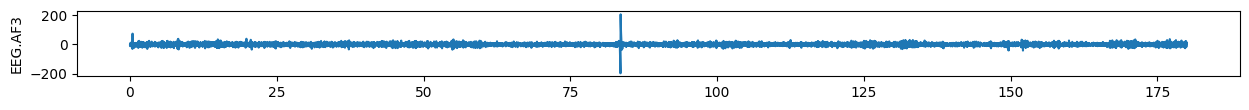

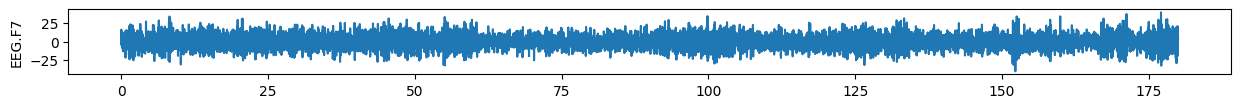

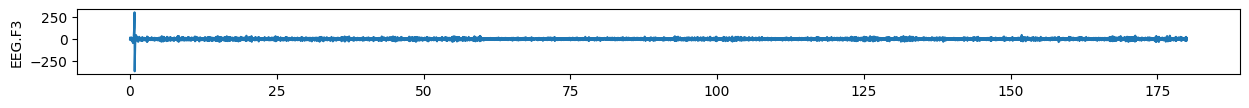

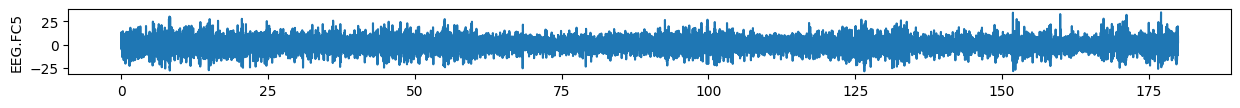

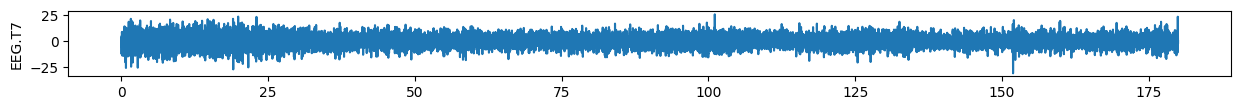

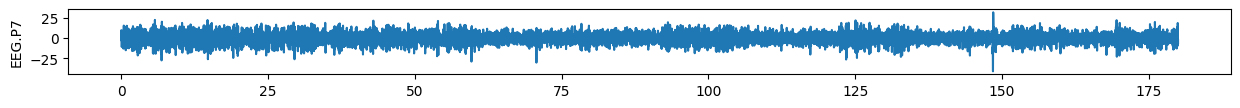

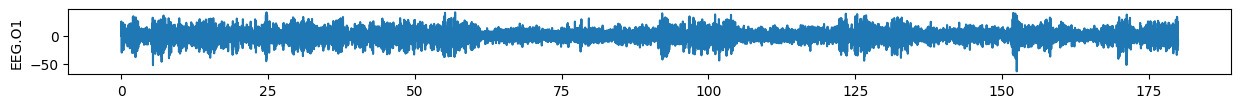

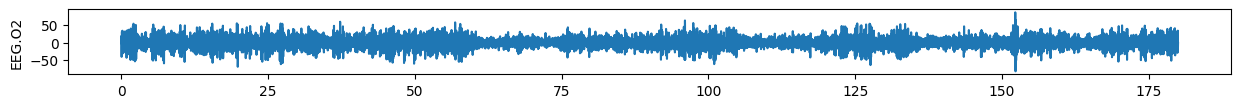

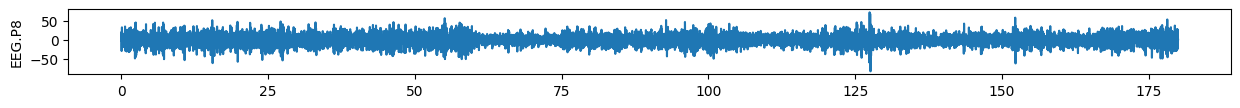

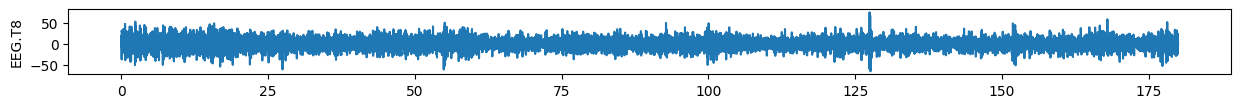

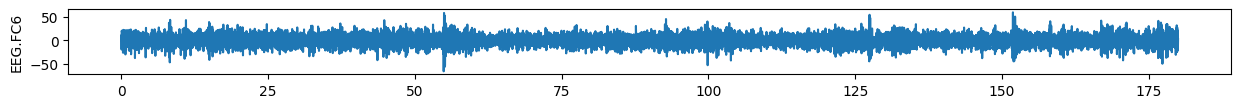

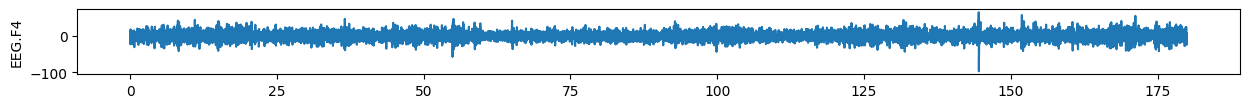

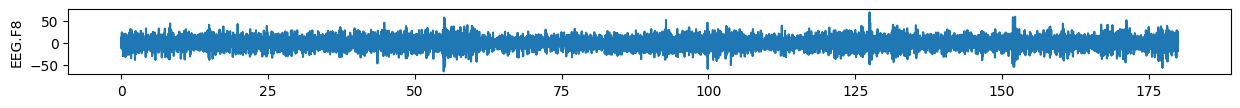

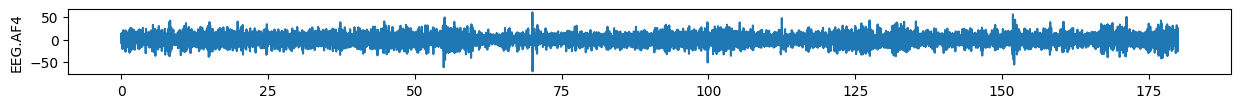

In [14]:
for i in range (0,14):
    plt.figure(figsize=(15,15))
    plt.subplot(15,1,i+1) #(filas, columnas, i)
    plt.plot(t,np.array(datosfilt)[t1:t2,i])
    plt.ylabel(nombres[i])#itera sobre el nombre de las columnas para dar título a los gráficos
    plt.show()

Comentar que puedo sacar artefacto de AF3

* Llevar al promedio el artefacto que está en aprox 80 en AF3

Las gráficas anteriores corresponden a la actividad eléctrica en cada electrodo, podemos observar el efecto de filtrar para el voltaje. Sin embargo por la resolución temporal de las gráficas se dificulta observar los cambios en la actividad. Por esto será necesario reducir el tiempo inicial y el tiempo final para tener un efecto de zoom en la actividad de alguno de los canales. El código para este propósito se muestra a continuación:

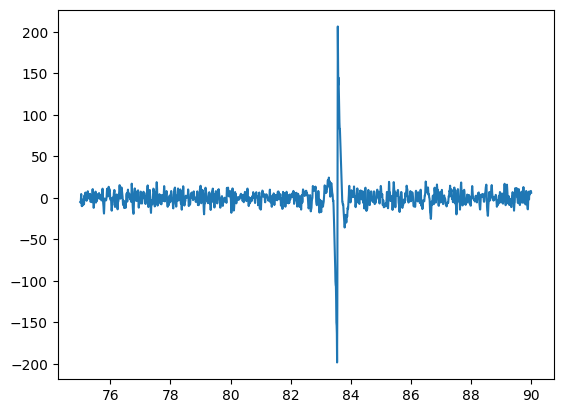

In [22]:
nc=0
fm=128 #frecuencia de muestreo
ti=75 #tiempo de inicio, debe ser número entero
tf=90 #tiempo final, debe ser número entero
pt=(tf-ti)*fm#numero de puntos
t1=ti*fm #nos ayuda a dar la posición de la fila para el tiempo inicial
t2=tf*fm #nos ayuda a dar la posición de la fila para el tiempo final
nombres=list(datos) #almacena los nombres de los encabezados en una lista
t=np.linspace(ti,tf,pt) 
volt=np.array(datosfilt)[t1:t2,nc]
plt.plot(t, volt)

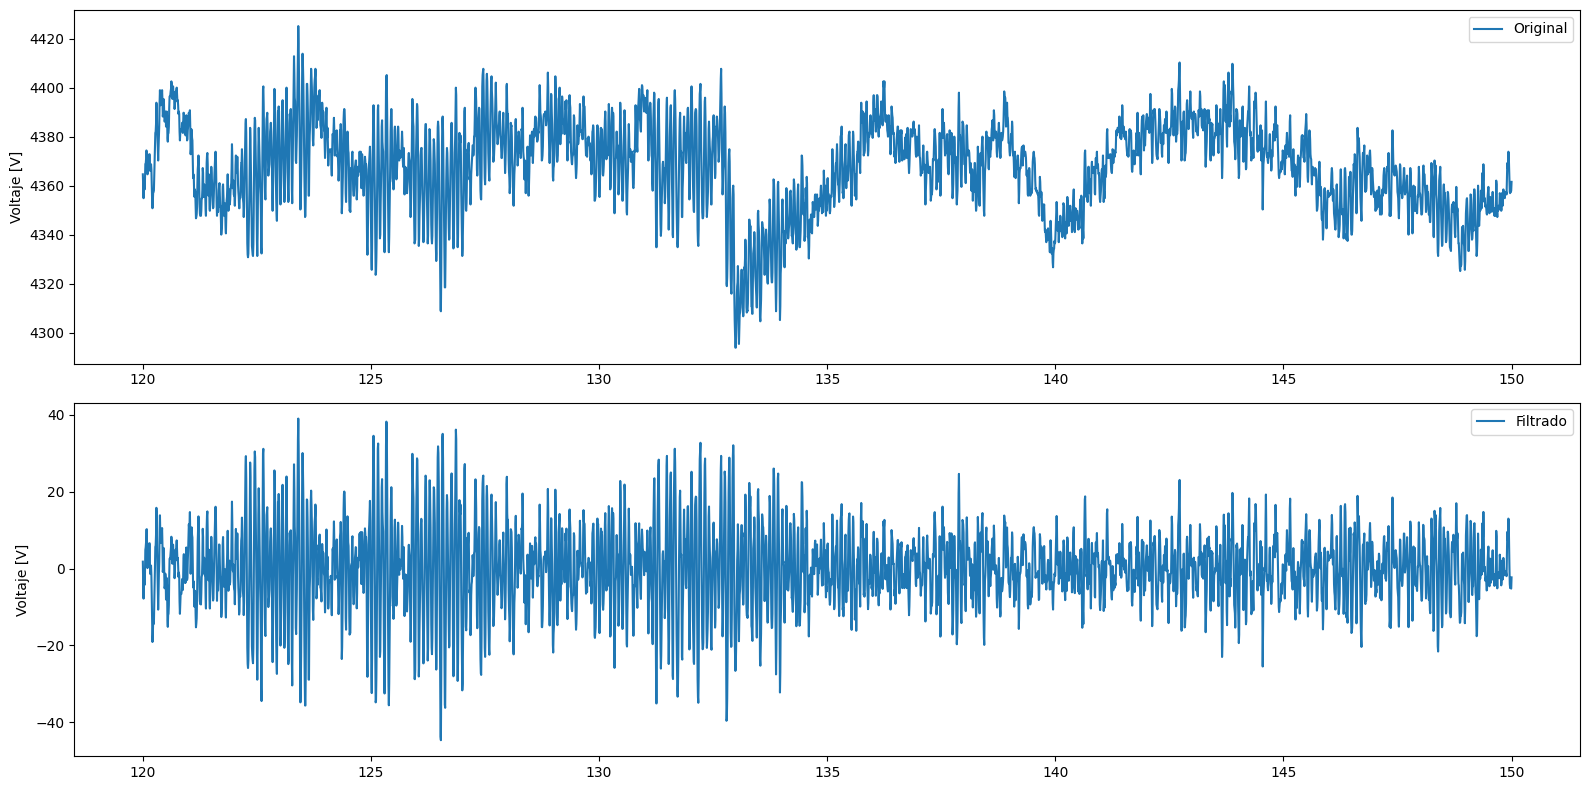

In [30]:
nc=6
ti_a=120
tf_a=150
pt=(tf_a-ti_a)*fm
t1_a=ti_a*fm
t2_a=tf_a*fm
t=np.linspace(ti_a,tf_a,pt) 
volt=np.array(datos)[t1_a:t2_a,nc]
volt_filt=np.array(datosfilt)[t1_a:t2_a,nc]
# Gráfica
figure, axis = plt.subplots(2, 1, figsize=(16, 8))

# Voltaje original
axis[0].plot(t, volt, label="Original")
axis[0].set_ylabel("Voltaje [V]")
axis[0].legend()

# Voltaje filtrado
axis[1].plot(t, volt_filt, label="Filtrado")
axis[1].set_ylabel("Voltaje [V]")
axis[1].legend()

# Ajustar la visualización
plt.tight_layout()

# Mostrar la gráfica
plt.show()

La visualización que se obtuvo facilitó observar los cambios de actividad en un periodo de tiempo más corto. Permitiendo de esta forma visualizar las distintas bandas de frecuencia, en particular la banda alfa, fundamental para nuestro análisis.

NECESITAMOS USAR FFT Y PSD PARA DETECTAR ALFAS.

Baseline correction with filters.
Filtro pasa altas para corrección del baseline..

## Transformada de Fourier


La transformada de Fourier es una herramienta matemática que permite descomponer una señal o función en una suma de funciones sinusoidales de diferentes frecuencias. Esto proporciona una representación en el dominio de la frecuencia de la señal o función original, lo que permite analizarla y manipularla de una manera más sencilla y eficiente. En otras palabras, la TF nos dice qué frecuencias están presentes en una señal y con qué intensidad.

Tiene aplicaciones en el análisis de señales, que serán relevantes en este notebook y los siguientes de la serie. Sirve para identificar las diferentes frecuencias que componen una señal, como las señales que se obtienen de técnicas como EEG superficial y EMG superficial. También funciona para comprimir señales al eliminar información redundante de la señal y dejar fuera frecuencias que no son del interés del análisis.

Hay dos aplicaciones puntuales que nos interesan para EEG.
* Identificación de bandas de frecuencia: La TF permite identificar y cuantificar la potencia espectral en diferentes bandas de frecuencia de interés, como las ondas alfa, beta, theta y delta, que se asocian con diferentes estados cognitivos y fisiológicos.

* Visualizar espectrogramas: La TF puede usarse para generar espectrogramas, que son representaciones visuales de la potencia espectral del EEG en función del tiempo y la frecuencia, lo que facilita la identificación de patrones y tendencias en la actividad cerebral.

## FFT

Son las siglas de Fast Fourier Transform, es decir: Transformada Rápida de Fourier. Es un algoritmo eficiente para calcular la Transformada Discreta de Fourier (DFT) y su inversa. La DFT es una herramienta matemática fundamental en el procesamiento de señales digitales que permite descomponer una señal en sus componentes de frecuencia. Indica qué frecuencias y con qué intensidad están representadas en la señal. 

Aplicaciones de la FFT:

* Fisiología: Se utiliza para analizar señales de electrocardiograma (ECG), electroencefalograma (EEG) y otras señales biomédicas.
* Electroencefalograma (EEG): La FFT se utiliza para analizar las diferentes bandas de frecuencia de las ondas cerebrales (delta, theta, alfa, beta y gamma), permitiendo evaluar el estado de alerta, la atención, la somnolencia, la actividad convulsiva y otras funciones cognitivas. 

Ventajas de la FFT:

* Eficiencia: La FFT es un algoritmo muy eficiente que puede calcular la DFT de manera rápida y precisa, incluso para señales largas y complejas.
* Versatilidad: La FFT se puede aplicar a una amplia variedad de tipos de señales, incluyendo señales de audio, imágenes, datos científicos y señales de control.
* Precisión: La FFT proporciona resultados precisos y confiables para el análisis de frecuencia de señales.



Text(0.5, 1.0, ' Transformada de Fourier de EEG')

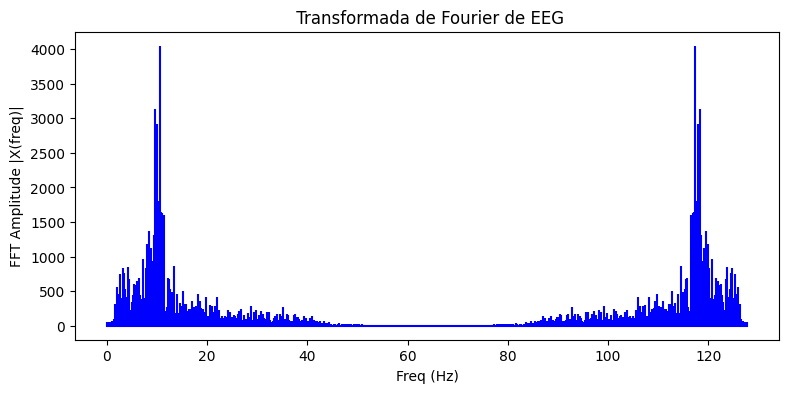

In [32]:
ta=5
tb=10
t_a=fm*ta
t_b=fm*tb
datosf=np.array(datosfilt)[t_a:t_b,7]
X = fft(datosf)
N = len(X)
n = np.arange(N)
T = N/fm
freq = n/T 

plt.figure(figsize = (20,4 ))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title(' Transformada de Fourier de EEG')

Parte real y parte compleja de FFT


(0.0, 64.0)

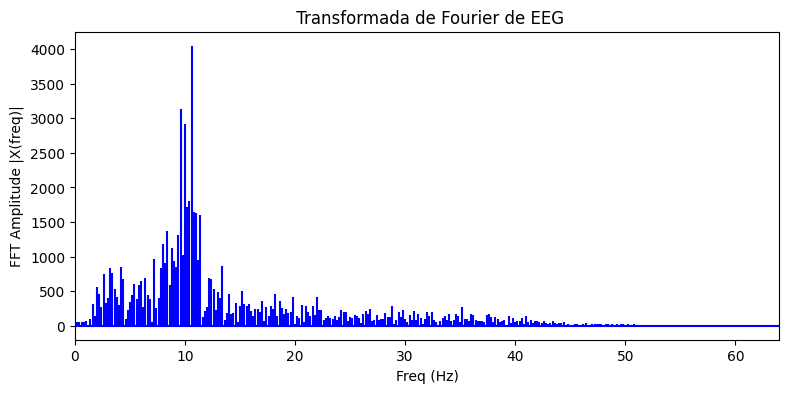

In [33]:
plt.figure(figsize = (20,4 ))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title(' Transformada de Fourier de EEG')
plt.xlim(0,64)

Las frecuencia de interés en este caso se encuentran en máximo 45 Hz. Con esta visualización tenemos una primera aproximación a las componentes de la señal, aunque se recomiendan otras visualizaciones que obtendremos más adelante.

## STFT con ventana de Bartlett

### STFT

La transformada de Fourier de corto tiempo (STFT) es una técnica para analizar señales no estacionarias, como las señales de audio o las señales de electroencefalografía (EEG). La STFT divide la señal en segmentos de tiempo cortos y luego aplica la transformada de Fourier a cada segmento. Esto permite obtener información tanto en el dominio del tiempo como en el de la frecuencia. Para aplicarla usamos los siguientes pasos: 

* División de la señal: La señal se divide en segmentos de tiempo cortos de longitud fija.
* Ventana: Se aplica una ventana a cada segmento para reducir la distorsión por ventana.
* Transformada de Fourier: Se aplica la transformada de Fourier a cada segmento de ventana.
* Cálculo de la magnitud y la fase: Se calcula la magnitud y la fase de los coeficientes de Fourier.
* Espectrograma: Se organiza la información de magnitud y fase en una matriz llamada espectrograma.

### Ventana de Bartlett 

La elección de una ventana está condicionada por varios factores, como la naturaleza de la señal, la precisión deseada y el tiempo de procesamiento disponible. En general, se recomienda utilizar la ventana de Bartlett cuando se desea reducir la distorsión por ventana y obtener una buena concentración espectral. Se define como:

$ w(n) = 1 - \frac{2}{N} \left( n - \frac{N-1}{2} \right)^2 $ 

donde N es la longitud de la ventana.

Tiene una serie de características relevantes para esta aplicación. Su forma es simétrica, tiene un ancho de banda amplio, tiene una buena concentración espectral. Además reduce la distorsión por ventana, la varianza de la estimación espectral y aumenta la resolución de frecuencia.

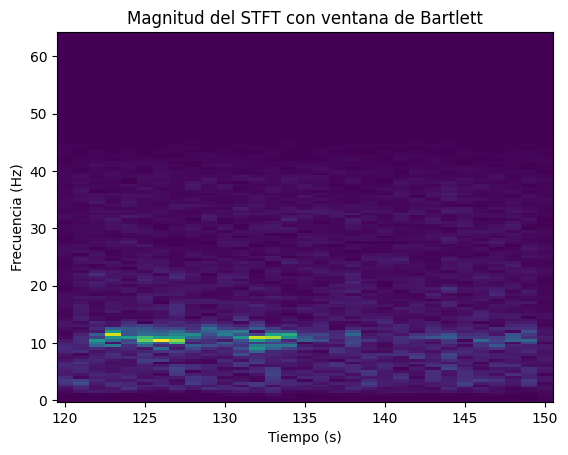

In [34]:
# Parámetros de entrada
N = pt
Fs = 128  # Frecuencia de muestreo
T = 1.0 / Fs  # Periodo de muestreo
N_muestras = N * T  # Número total de muestras

# Datos de la señal
y = np.array(datosfilt)[t1_a:t2_a, 6]
longitud_senal = len(y)
longitud_ventana = 256
# Ventana de Bartlett
ventana = scipy.signal.windows.bartlett(longitud_ventana)  # Ajustar la longitud según sea necesario

# Seleccionar longitud de ventana y superposición
  # Ajustar según sus necesidades
superposicion = 128  # Ajustar según sus necesidades

# Asegurar una superposición válida
superposicion = min(longitud_ventana - 1, max(0, superposicion))

# Resolución de frecuencia
resolucion_frecuencia = Fs / float(longitud_ventana)

# Calcular STFT con ventana de Bartlett
f, t, Zxx = scipy.signal.stft(y, fs=Fs, window=ventana, nperseg=longitud_ventana, noverlap=superposicion)

# Visualizar la magnitud del STFT
plt.pcolormesh(t+ti_a, f, np.abs(Zxx), shading='auto')
plt.title('Magnitud del STFT con ventana de Bartlett')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.show()

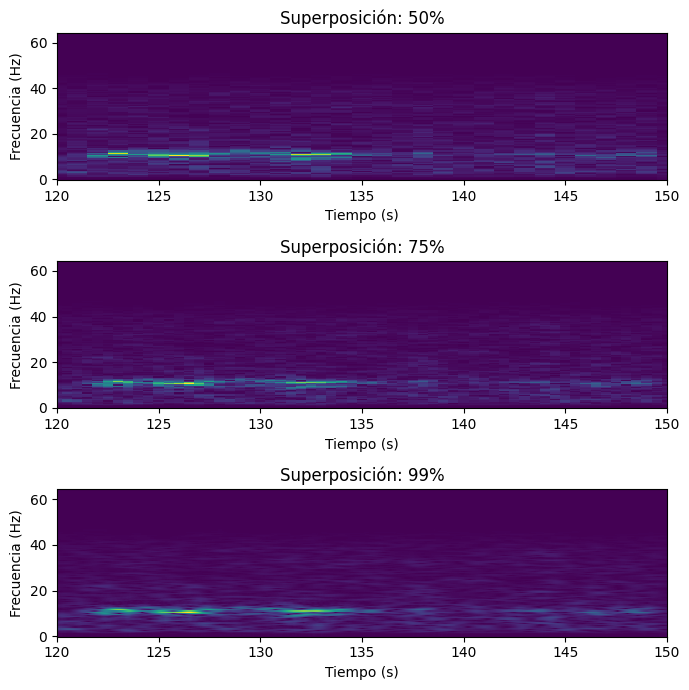

In [35]:
# Parámetros de entrada
fm=128 #frecuencia de muestreo
N = pt
# Frecuencia de muestreo
T = 1.0 / fm  # Periodo de muestreo
t=np.arange(ti_a, tf_a, 1.0 / fm)
N_muestras = N * T  # Número total de muestras
longitud_ventana=256

# Datos de la señal
y = np.array(datosfilt)[t1_a:t2_a, 6]
longitud_senal = len(y)

# Ventana de Bartlett
ventana = scipy.signal.windows.bartlett(longitud_ventana)  # Ajustar la longitud según sea necesario

# Definir superposiciones
superposiciones = [0.5, 0.75, 0.99]

# Figuras para las gráficas
fig, axs = plt.subplots(len(superposiciones), 1,figsize=(7, 7))

for i, superposicion in enumerate(superposiciones):
    # Ajustar la superposición
    noverlap = int(longitud_ventana * superposicion)

    # Calcular STFT
    f, t, Zxx = scipy.signal.stft(y, fs=fm, window=ventana, nperseg=longitud_ventana, noverlap=noverlap)

    # Visualizar la magnitud del STFT
    axs[i].pcolormesh(t+ti_a, f, np.abs(Zxx), shading='auto')
    axs[i].set_title(f'Superposición: {superposicion:.0%}')
    axs[i].set_xlabel('Tiempo (s)')
    axs[i].set_xlim([ti_a, tf_a])
    axs[i].set_ylabel('Frecuencia (Hz)')
plt.tight_layout()
plt.show()

### Poner como ejercicio 

* Fourier
* Welch
* Espectrogramas
* Ventana de Bartlett

### ¿Cómo afecta la superposición de ventanas ?
1. Reducción de la varianza: La superposición promedia múltiples segmentos de la señal, lo que reduce la varianza de la estimación espectral. Esto significa que la estimación espectral será más precisa y estable, especialmente para señales con baja potencia.

2. Aumento de la resolución en frecuencia: La superposición aumenta el número de puntos de frecuencia que se estiman, lo que mejora la resolución en frecuencia del análisis. Esto permite observar detalles más finos en el espectro de la señal.

3. Reducción de la distorsión por ventana: La superposición reduce la distorsión por ventana, que se produce cuando la ventana seleccionada no captura completamente la periodicidad de la señal. Esto mejora la precisión de la estimación espectral, especialmente para señales con transitorios o cambios rápidos en la frecuencia.

4. Aumento del tiempo de procesamiento: La superposición aumenta el tiempo de procesamiento necesario para calcular la transformada de Fourier de corto tiempo (STFT). Esto se debe a que se requiere calcular la STFT para cada segmento de la señal superpuesta.

5. Pérdida de información temporal: La superposición puede provocar la pérdida de información temporal, ya que se promedian segmentos de la señal que no son contiguos en el tiempo. Esto puede ser un problema para el análisis de señales que contienen eventos transitorios o cambios rápidos en la amplitud.

## Bibliografía
* Baranowski, J., & Piątek, P. (2017). Fractional band-pass filters: design, implementation and application to EEG signal processing. Journal of Circuits, Systems and Computers, 26(11), 1750170.
* Pant, A., & Kumar, A. (2024). Hanning FIR window filtering analysis for EEG signals. Biomedical Analysis, 1(2), 111-123.
* Rader, C. M., & Gold, B. (1967). Digital filter design techniques in the frequency domain. Proceedings of the IEEE, 55(2), 149-171.
* Shoka, A., Dessouky, M., El-Sherbeny, A., & El-Sayed, A. (2019). Literature review on EEG preprocessing, feature extraction, and classifications techniques. Menoufia J. Electron. Eng. Res, 28(1), 292-299.
* Schreiber, G., Lin, H., Garza, J., Zhang, Y., & Yang, M. (2017). EEG visualization and analysis techniques. Health Informatics Data Analysis: Methods and Examples, 155-168.
* Vallat, R., Meunier, D., Nicolas, A., & Ruby, P. (2019). Hard to wake up? The cerebral correlates of sleep inertia assessed using combined behavioral, EEG and fMRI measures. NeuroImage, 184, 266-278.
* Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data–a practical approach. Journal of neuroscience methods, 250, 34-46.

* Ventana de 2 segundos para alfa para detectar eventos